In [117]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from statsmodels.api import OLS
from statsmodels.tools import add_constant
from ucimlrepo import fetch_ucirepo

np.set_printoptions(precision=4, suppress=True)

# Estimating wine quality

GitHub repo: https://github.com/mdholloway/WineQuality

In this project I analyze an open-licensed dataset on wine quality. The features of the dataset consist of various properties, such as the amounts of citric acid, sulphates, and residual sugar, of approximately 6,500 Portuguese vinho verde wines, and the  target is the wine's rating by taste testers on a 1-10 scale. The goal is to use supervised learning methods to find the best classifier for predicting the quality of wines based on their physico-chemical properties.

In [118]:
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  
# variable information 
print(wine_quality.variables) 

                    name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Other  Categorical        None   

               description units missing_values  
0                     None  None             no  
1                     None  Non

In [119]:
len(X)

6497

A convenient aspect of this dataset is that the features consist exclusively of continuous variables. On the other hand, the target is a bit tricky because it's an ordered categorical variable rather than a continuous variable. An additional difficulty is that the membership of the target categories is not evenly distributed, but heavily skewed toward wines of average quality (5 or 6). This means that our classifier's task will largely consist of finding distinctions between slightly better and slightly worse wines of about average quality.

Of the 6,497 wines in the dataset, 2,836 (43.65%) have an assessed quality of 6 out of 10, so we'll seek at a minimum to produce a classifier with a better overall accuracy than the 0.44 we could achieve by always predicting a quality rating of 6.

In [120]:
y.groupby('quality').size()

quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
dtype: int64

Digging into the correlations, we can see that many features are mildly to moderately correlated. Two feature pairs are particularly highly correlated: alcohol and density have a strong negative correlation of -0.69, and free_sulfur_dioxide and total_sulfur_dioxide are (unsurprisingly) strongly correlated at 0.72.

<Axes: >

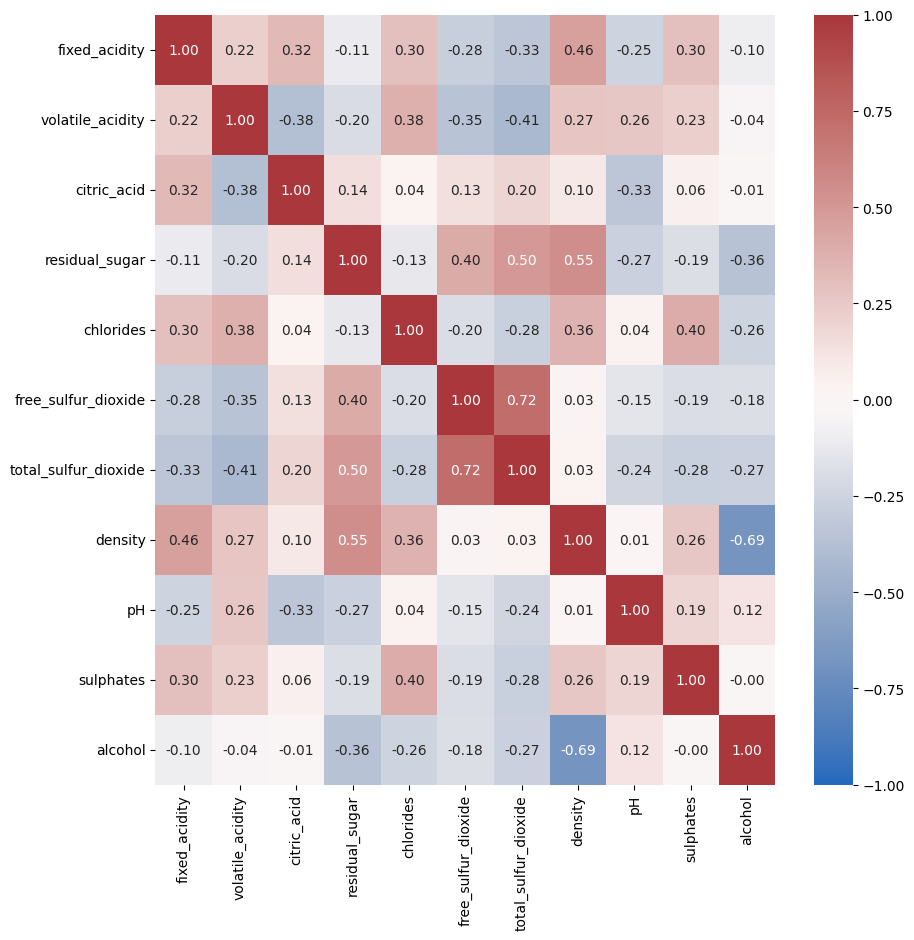

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(X.corr(), cmap='vlag', cbar=True, annot=True, fmt='.2f', xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

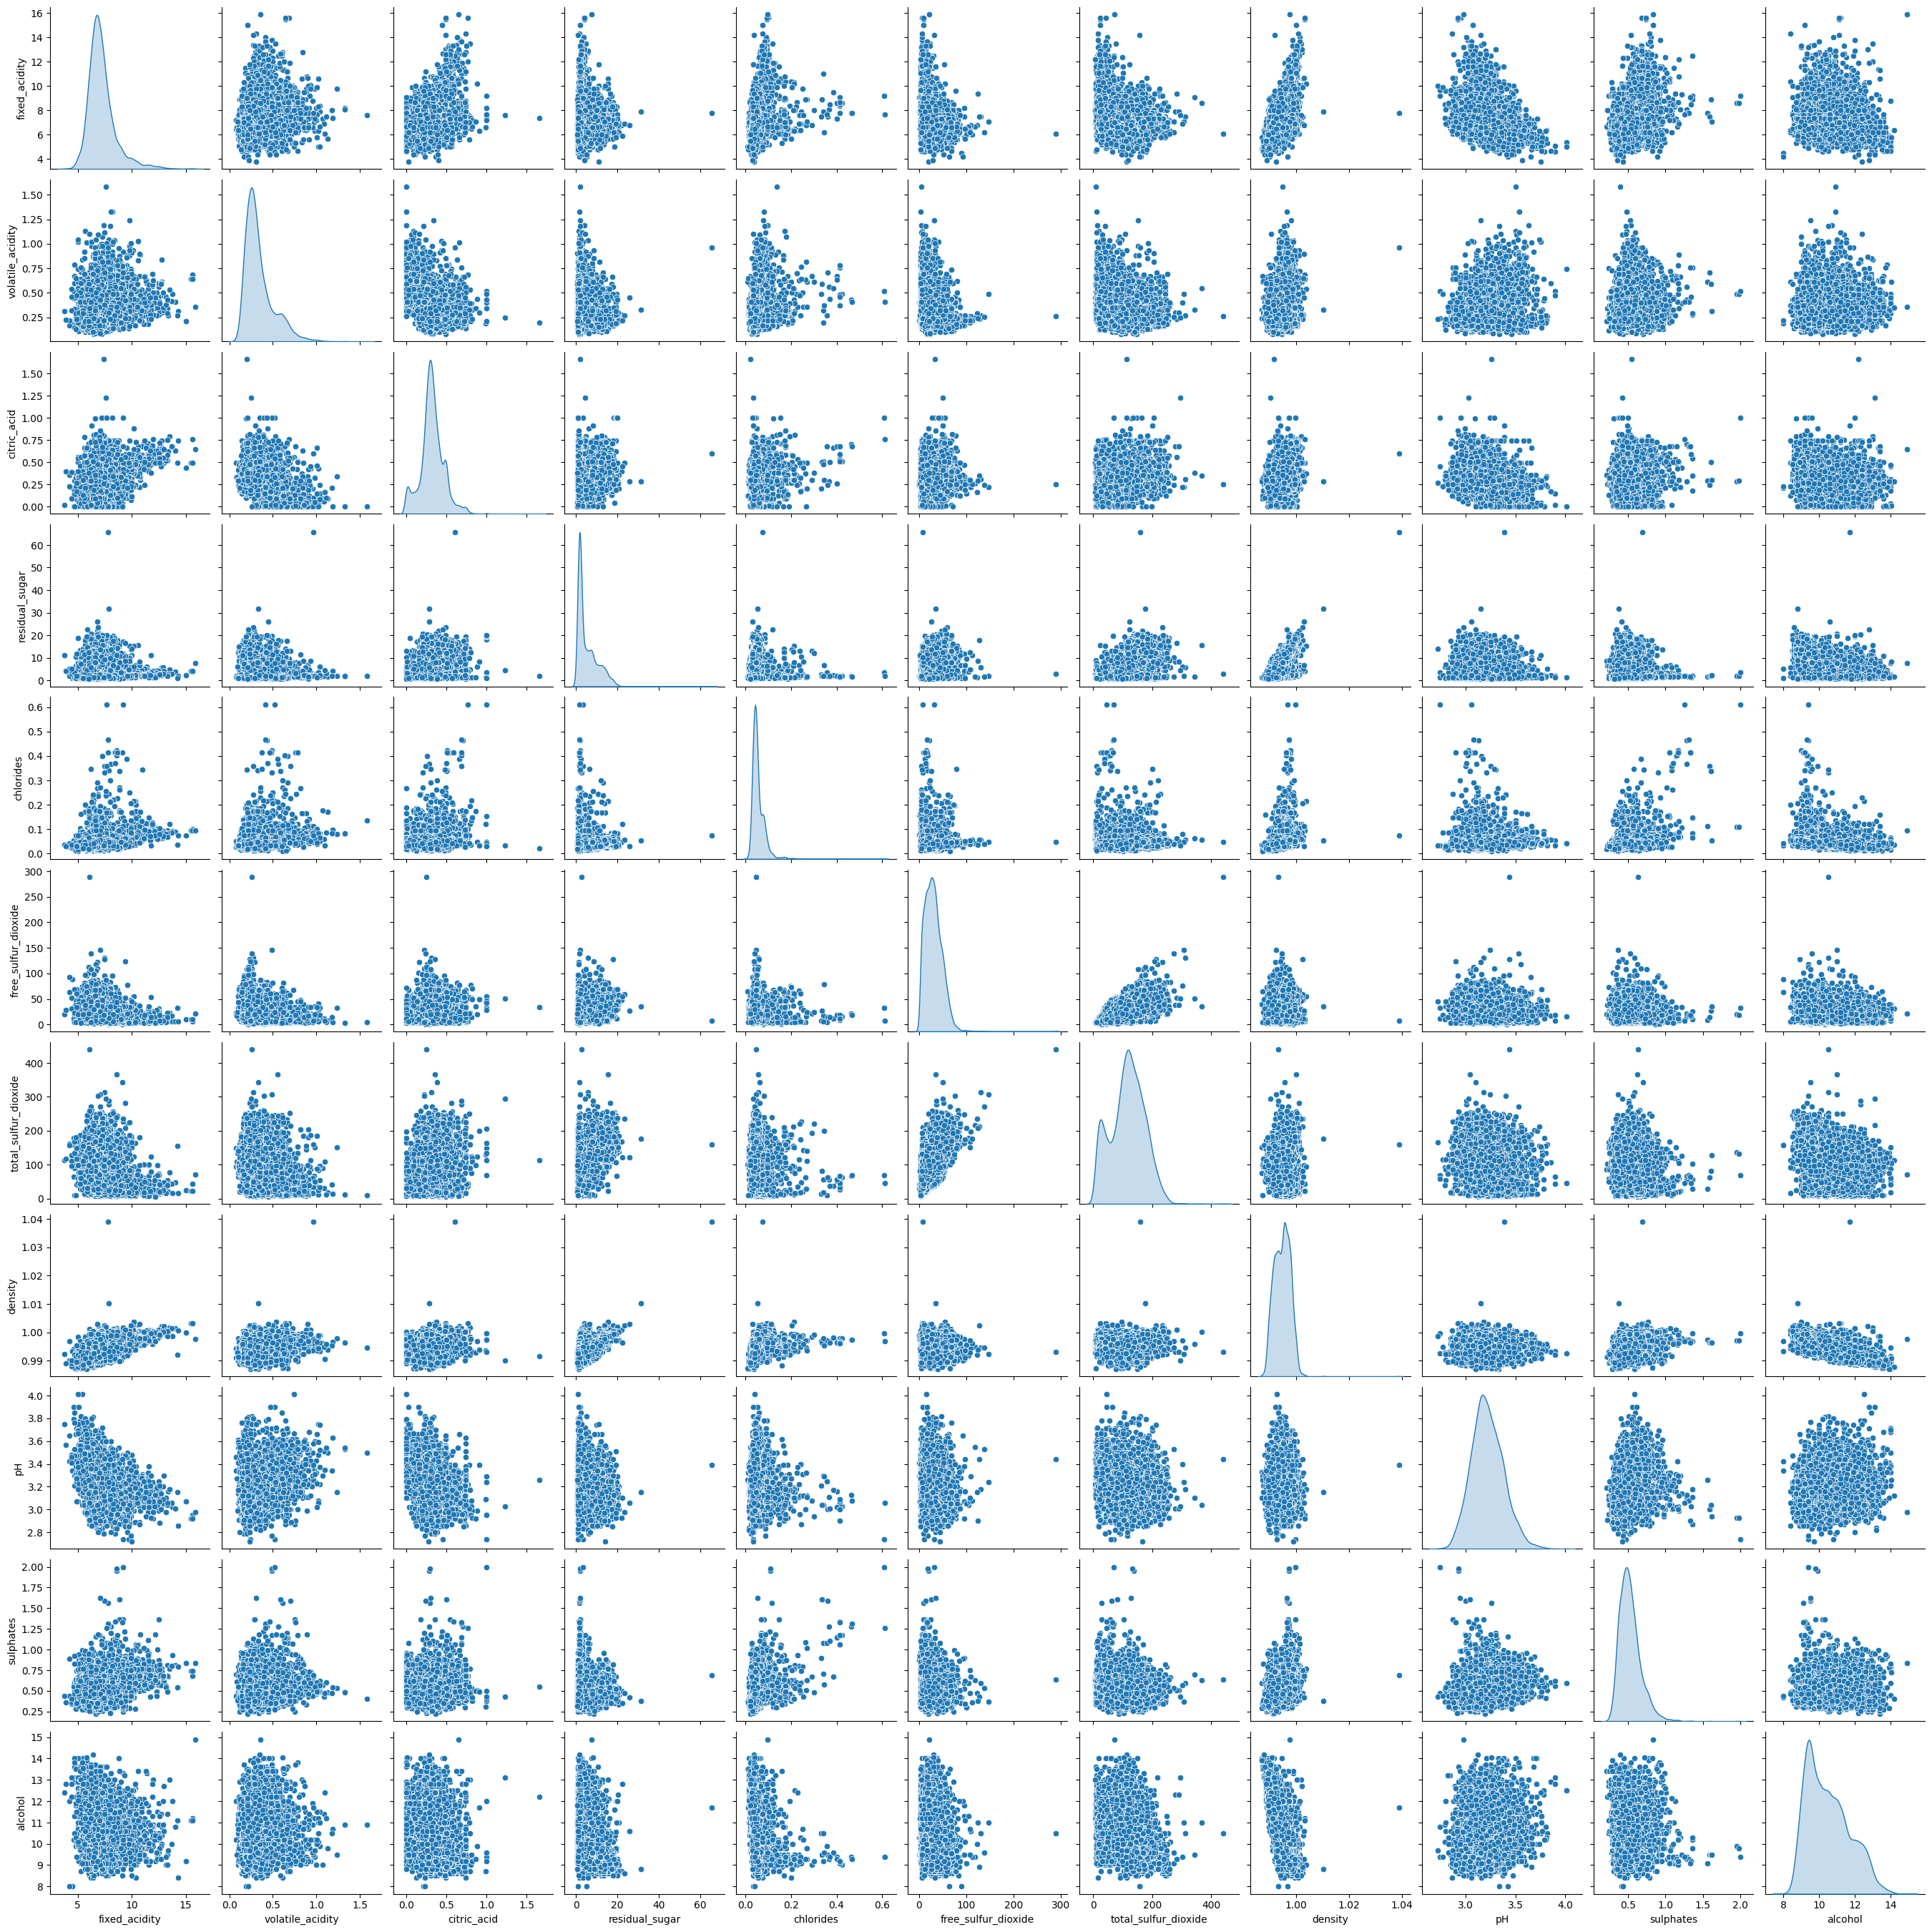

In [16]:
sns.pairplot(X, diag_kind='kde')

## Linear regression

Let's start with an ordinary least squares regression model. Plugging in all features, we see that most are highly statistically significant, but the overall model has little predictive power, with an R-squared value of 0.29.

In [121]:
scaler = StandardScaler().set_output(transform='pandas')
X_std = scaler.fit_transform(X)
X_std_const = add_constant(X_std)

In [122]:
ols = OLS(y, X_std_const).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     243.3
Date:                Wed, 11 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:16:10   Log-Likelihood:                -7215.5
No. Observations:                6497   AIC:                         1.445e+04
Df Residuals:                    6485   BIC:                         1.454e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.8184      0.009    637.785      0.000       5.800       5.836
fixed_acidity            0.0877      0.020      4.346      0.000       0.048       0.127
volatile_acidity        -0.2186      0.013    -17.162      0.000      -0.244      -0.194
citric_acid             -0.0159      0.012     -1.377      0.168      -0.039       0.007
residual_sugar           0.2072      0.025      8.449      0.000       0.159       0.255
chlorides               -0.0169      0.012     -1.454      0.146      -0.040       0.006
free_sulfur_dioxide      0.1060      0.013      7.948      0.000       0.080       0.132
total_sulfur_dioxide    -0.1402      0.016     -8.969      0.000      -0.171      -0.110
density                 -0.1648      0.036     -4.529      0.000      -0.236      -0.093
pH                       0.0706      0.015      4.861      0.000       0.042       0.099
sulphates                0.1143      0.011     10.092      0.000       0.092       0.137
alcohol                  0.3185      0.020     15.963      0.000       0.279       0.358
==============================================================================
Omnibus:                      144.075   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              324.712
Skew:                          -0.006   Prob(JB):                     3.09e-71
Kurtosis:                       4.095   Cond. No.                         9.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The citric_acid and chlorides features fail to meet the threshold of statistical signifance in the OLS model, so we can drop them, but doing so has little effect on the model overall.

In [123]:
X_std_const = X_std_const.drop(columns=['citric_acid', 'chlorides'])
ols = OLS(y, X_std_const).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     296.7
Date:                Wed, 11 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:16:17   Log-Likelihood:                -7217.8
No. Observations:                6497   AIC:                         1.446e+04
Df Residuals:                    6487   BIC:                         1.452e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.8184      0.009    637.650      0.000       5.800       5.836
fixed_acidity            0.0858      0.019      4.412      0.000       0.048       0.124
volatile_acidity        -0.2147      0.012    -18.445      0.000      -0.238      -0.192
residual_sugar           0.2157      0.024      9.024      0.000       0.169       0.263
free_sulfur_dioxide      0.1053      0.013      7.911      0.000       0.079       0.131
total_sulfur_dioxide    -0.1415      0.015     -9.217      0.000      -0.172      -0.111
density                 -0.1782      0.036     -5.004      0.000      -0.248      -0.108
pH                       0.0769      0.014      5.411      0.000       0.049       0.105
sulphates                0.1098      0.011      9.903      0.000       0.088       0.132
alcohol                  0.3156      0.020     15.886      0.000       0.277       0.355
==============================================================================
Omnibus:                      144.178   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.085
Skew:                          -0.004   Prob(JB):                     2.56e-71
Kurtosis:                       4.096   Cond. No.                         9.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The OLS model has substantially less predictive power than our baseline strategy of always choosing 6. This is likely in part because OLS regression is meant to predict values on a continuous rather than a categorical target. Because our target categories in this case are ordered numeric values, it is possible to interpret predicted quality values produced by this model against them (e.g., by rounding to the nearest integer), but this comes with a substantial loss of precision.

## K-nearest neighbors

We'll achieve better results with non-parametric models that are better suited to handling categorical targets. We'll start with k-nearest neighbors.

Using scikit-learn's builtin KNeighborsClassifier with default parameters (including a default k=5) results in a classifier with an overall accuracy score of approximately 0.5. Much better than our OLS model and slightly better than always choosing 6, but still not great.

In [124]:
# Default k=5
knn = KNeighborsClassifier().fit(X_train, y_train['quality'])
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=np.nan))

              precision    recall  f1-score   support

           3        nan      0.00      0.00         5
           4       0.17      0.14      0.15        37
           5       0.50      0.58      0.53       416
           6       0.55      0.57      0.56       584
           7       0.42      0.32      0.37       221
           8       0.56      0.14      0.22        36
           9        nan      0.00      0.00         1

    accuracy                           0.50      1300
   macro avg       0.44      0.25      0.26      1300
weighted avg       0.50      0.50      0.50      1300



The confusion matrix shows, as we'd expect, that the bulk of our misclassifications consist of categorizing 5s as 6s and vice-versa.

In [125]:
confusion_matrix(y_test, y_pred)

array([[  0,   0,   1,   2,   2,   0,   0],
       [  0,   5,  17,  12,   3,   0,   0],
       [  0,   5, 240, 147,  23,   1,   0],
       [  0,  13, 175, 335,  59,   2,   0],
       [  0,   5,  42, 102,  71,   1,   0],
       [  0,   1,   7,  13,  10,   5,   0],
       [  0,   0,   0,   1,   0,   0,   0]])

Building a succession of kNN classifiers while iterating over values of k yields an interesting finding: accuracy is maximized at over 0.59 with k=1, and falls sharply with k=2 before settling in the high 40s with k=3 and higher.

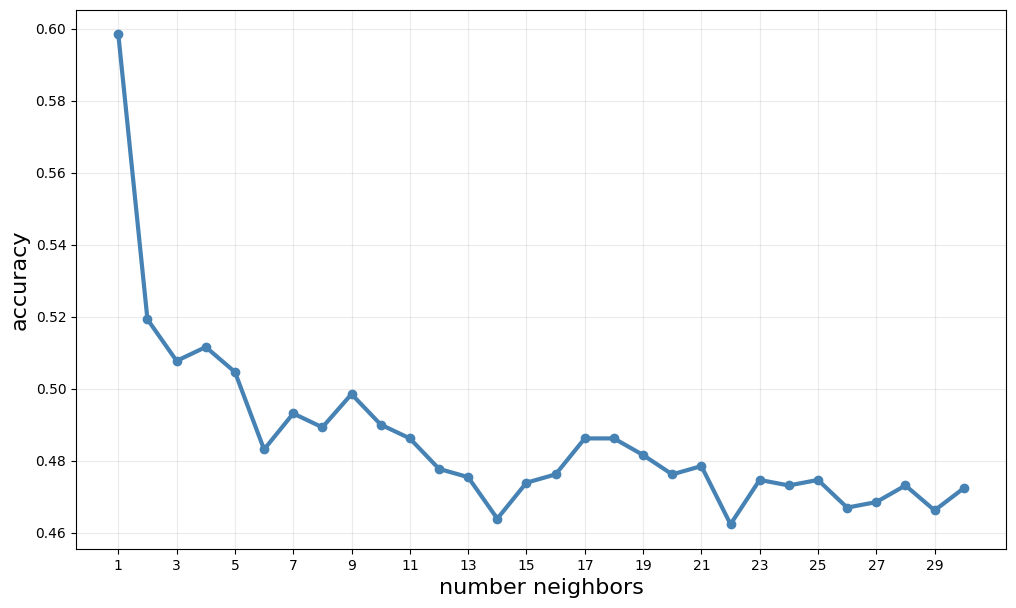

In [126]:
allks = range(1,31)
acc = []
for k in allks:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train['quality'])
    y_pred = knn.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allks, acc, marker="o", color="steelblue", lw=3, label="unweighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.xticks(range(1,31,2))
ax.grid(alpha=0.25)

In [127]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train['quality'])
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=np.nan))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.13      0.16      0.14        37
           5       0.66      0.64      0.65       416
           6       0.64      0.65      0.64       584
           7       0.52      0.53      0.52       221
           8       0.39      0.31      0.34        36
           9       0.00      0.00      0.00         1

    accuracy                           0.60      1300
   macro avg       0.33      0.33      0.33      1300
weighted avg       0.60      0.60      0.60      1300



With a one-nearest neighbor model we're starting to see reasonable precision and recall scores for most target categories and overall accuracy of about 0.6. Getting warmer!

## Decision tree

A decision tree classifier performs about the same as our one-nearest neighbor model, achieving overall accuracy of about 0.6.

In [128]:
dtree = DecisionTreeClassifier().fit(X_train, y_train['quality'])
y_pred = dtree.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=np.nan))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.22      0.22      0.22        37
           5       0.65      0.65      0.65       416
           6       0.63      0.60      0.62       584
           7       0.49      0.57      0.53       221
           8       0.37      0.36      0.37        36
           9        nan      0.00      0.00         1

    accuracy                           0.59      1300
   macro avg       0.39      0.34      0.34      1300
weighted avg       0.59      0.59      0.59      1300



Iterating over a range of possible values of the max_depth and max_leaf_nodes parameters, we can see that the values quickly stablize after the values increase above 1. In practice, after experimenting, constraining these rather than taking the default behavior (no maximum depth or leaf nodes) resulted in worse performance on the test data set.

In [89]:
for i in range(1, 26):
    dtree = DecisionTreeClassifier(max_depth=i).fit(X_train, y_train['quality'])
    print('Max depth ' + str(i) + ' accuracy: ' + str(dtree.score(X_test, y_test['quality'])))

Max depth 1 accuracy: 0.49
Max depth 2 accuracy: 0.5192307692307693
Max depth 3 accuracy: 0.5230769230769231
Max depth 4 accuracy: 0.5538461538461539
Max depth 5 accuracy: 0.5561538461538461
Max depth 6 accuracy: 0.5546153846153846
Max depth 7 accuracy: 0.5738461538461539
Max depth 8 accuracy: 0.5753846153846154
Max depth 9 accuracy: 0.5784615384615385
Max depth 10 accuracy: 0.58
Max depth 11 accuracy: 0.5853846153846154
Max depth 12 accuracy: 0.5876923076923077
Max depth 13 accuracy: 0.5838461538461538
Max depth 14 accuracy: 0.5923076923076923
Max depth 15 accuracy: 0.5892307692307692
Max depth 16 accuracy: 0.5930769230769231
Max depth 17 accuracy: 0.6
Max depth 18 accuracy: 0.5915384615384616
Max depth 19 accuracy: 0.5892307692307692
Max depth 20 accuracy: 0.5992307692307692
Max depth 21 accuracy: 0.5969230769230769
Max depth 22 accuracy: 0.5961538461538461
Max depth 23 accuracy: 0.6023076923076923
Max depth 24 accuracy: 0.6
Max depth 25 accuracy: 0.5976923076923077


In [90]:
for i in range(2, 26):
    dtree = DecisionTreeClassifier(max_leaf_nodes=i).fit(X_train, y_train['quality'])
    print('Max leaf nodes ' + str(i) + ' accuracy: ' + str(dtree.score(X_test, y_test['quality'])))

Max leaf nodes 2 accuracy: 0.49
Max leaf nodes 3 accuracy: 0.5192307692307693
Max leaf nodes 4 accuracy: 0.5192307692307693
Max leaf nodes 5 accuracy: 0.5192307692307693
Max leaf nodes 6 accuracy: 0.5192307692307693
Max leaf nodes 7 accuracy: 0.5384615384615384
Max leaf nodes 8 accuracy: 0.5384615384615384
Max leaf nodes 9 accuracy: 0.5307692307692308
Max leaf nodes 10 accuracy: 0.5346153846153846
Max leaf nodes 11 accuracy: 0.5346153846153846
Max leaf nodes 12 accuracy: 0.5346153846153846
Max leaf nodes 13 accuracy: 0.5384615384615384
Max leaf nodes 14 accuracy: 0.5392307692307692
Max leaf nodes 15 accuracy: 0.54
Max leaf nodes 16 accuracy: 0.5415384615384615
Max leaf nodes 17 accuracy: 0.5453846153846154
Max leaf nodes 18 accuracy: 0.5507692307692308
Max leaf nodes 19 accuracy: 0.5507692307692308
Max leaf nodes 20 accuracy: 0.5507692307692308
Max leaf nodes 21 accuracy: 0.5507692307692308
Max leaf nodes 22 accuracy: 0.5507692307692308
Max leaf nodes 23 accuracy: 0.5507692307692308
Ma

Plotting a depth-constrained version of the decision tree gives us an interesting perspective on the data. We can see that the alcohol content of the wine is the single most important determinant of its quality, followed by its volatile acidity. In this simple model, a wine is assigned a quality score of 6 if it has an ABV greater than 10.625, and a 5 if less than 10.625, unless it also has volatile acidity of <= 0.287 g(acetic acid)/dm^3, in which case it is assigned a 6 after all.

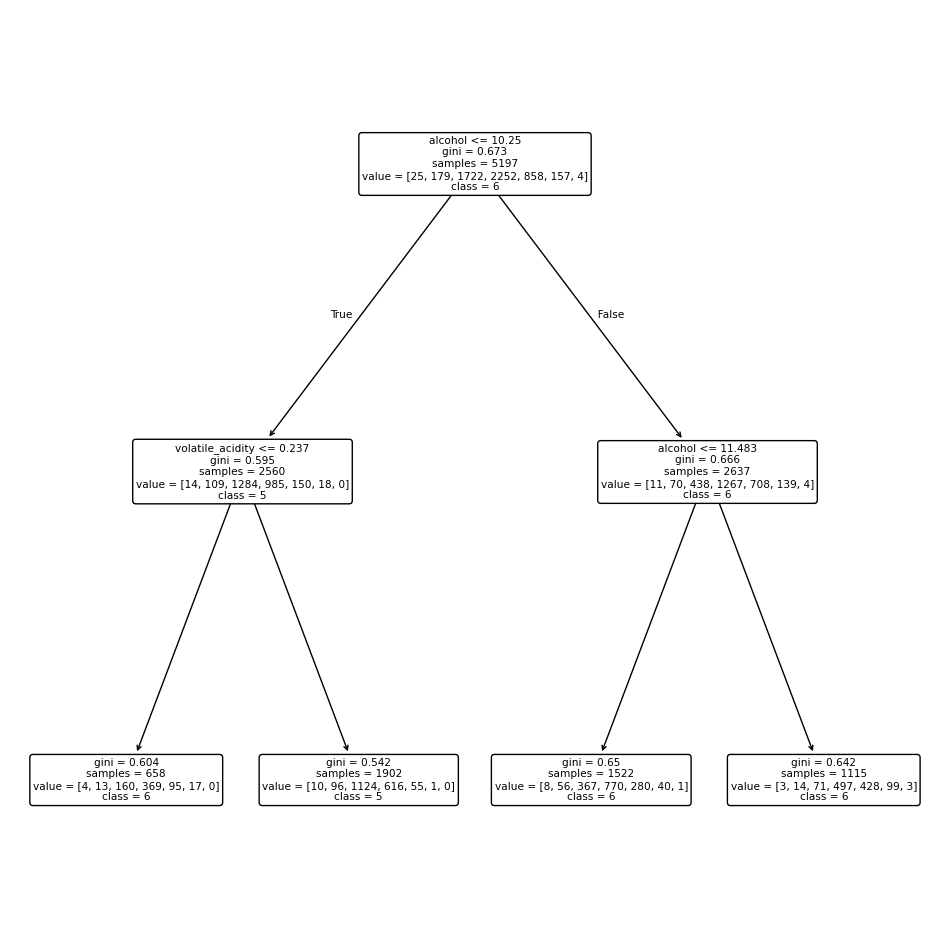

In [129]:
dtree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train['quality'])
plt.figure(figsize=(12,12))
plot_tree(dtree, rounded=True, feature_names=wine_quality.variables.name, class_names=[str(n) for n in range(3, 10)])
plt.show()

## Random forest

Our best performance yet is achieved with random forest classifiers, which achieve overall accuracy scores of around 0.70. This makes intuitive sense, as the randomly chosen subsets of features used in the subtrees likely allow us to capture nuances lost in models dominated by the powerful effects of features like alcohol and volatile acidity.

In [130]:
rf = RandomForestClassifier().fit(X_train, y_train['quality'])
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=np.nan))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.86      0.16      0.27        37
           5       0.74      0.75      0.75       416
           6       0.67      0.79      0.73       584
           7       0.69      0.52      0.60       221
           8       0.79      0.31      0.44        36
           9        nan      0.00      0.00         1

    accuracy                           0.70      1300
   macro avg       0.62      0.36      0.40      1300
weighted avg       0.70      0.70      0.69      1300



As in the simple decision tree model, constraining the subtree max depth worsens performance on the test sample.

In [131]:
rf = RandomForestClassifier(max_depth=10).fit(X_train, y_train['quality'])
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=np.nan))

              precision    recall  f1-score   support

           3        nan      0.00      0.00         5
           4       1.00      0.03      0.05        37
           5       0.71      0.69      0.70       416
           6       0.61      0.79      0.69       584
           7       0.67      0.40      0.50       221
           8       0.70      0.19      0.30        36
           9        nan      0.00      0.00         1

    accuracy                           0.65      1300
   macro avg       0.74      0.30      0.32      1300
weighted avg       0.67      0.65      0.63      1300



## Gradient boosting

Gradient boosting, another ensemble learning method, achieves worse results than a random forest model when using the default parameters. With a constrained max depth and a much larger number of estimators, it approaches the quality of our random forest model, though it takes noticeably longer to train.

In [113]:
gb = GradientBoostingClassifier().fit(X_train, y_train['quality'])
y_pred = gb.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=np.nan))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.64      0.15      0.24        48
           5       0.65      0.66      0.66       413
           6       0.56      0.72      0.63       568
           7       0.58      0.35      0.44       220
           8       0.60      0.13      0.22        45
           9        nan      0.00      0.00         1

    accuracy                           0.59      1300
   macro avg       0.51      0.29      0.31      1300
weighted avg       0.60      0.59      0.58      1300



In [114]:
gb = GradientBoostingClassifier(n_estimators=1000, max_depth=10).fit(X_train, y_train['quality'])
y_pred = gb.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=np.nan))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.65      0.27      0.38        48
           5       0.72      0.75      0.73       413
           6       0.65      0.74      0.69       568
           7       0.66      0.53      0.59       220
           8       0.86      0.42      0.57        45
           9        nan      0.00      0.00         1

    accuracy                           0.68      1300
   macro avg       0.59      0.39      0.42      1300
weighted avg       0.68      0.68      0.67      1300



## Support vector classifier

Our final model is the support vector classifier. Of the builtin kernels provided by scikit-learn, the linear kernel performs best on this dataset, though it is slow to train, and the resulting accuracy (apparently achieved in part by predicting exclusively 5 or 6) is inferior to that of our boosted models and even our standard decision tree model.

In [115]:
svc = SVC(kernel='linear').fit(X_train, y_train['quality'])
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=np.nan))

              precision    recall  f1-score   support

           3        nan      0.00      0.00         5
           4        nan      0.00      0.00        48
           5       0.58      0.61      0.60       413
           6       0.50      0.76      0.60       568
           7        nan      0.00      0.00       220
           8        nan      0.00      0.00        45
           9        nan      0.00      0.00         1

    accuracy                           0.52      1300
   macro avg       0.54      0.20      0.17      1300
weighted avg       0.53      0.52      0.45      1300



In [4]:
## Supporting code copied from the Week 6 lab!

class midpoint_normalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_search_grid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=midpoint_normalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()

I attempted to search for better parameters, but I was only able to search a relatively small range due to the lengthy training time required for training these models. The search below took several hours on my laptop and did not yield very interesting results. With more time and computing power, it may be possible to find a better performing support vector machine model for this data, perhaps using a different kernel.

/Users/michael/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


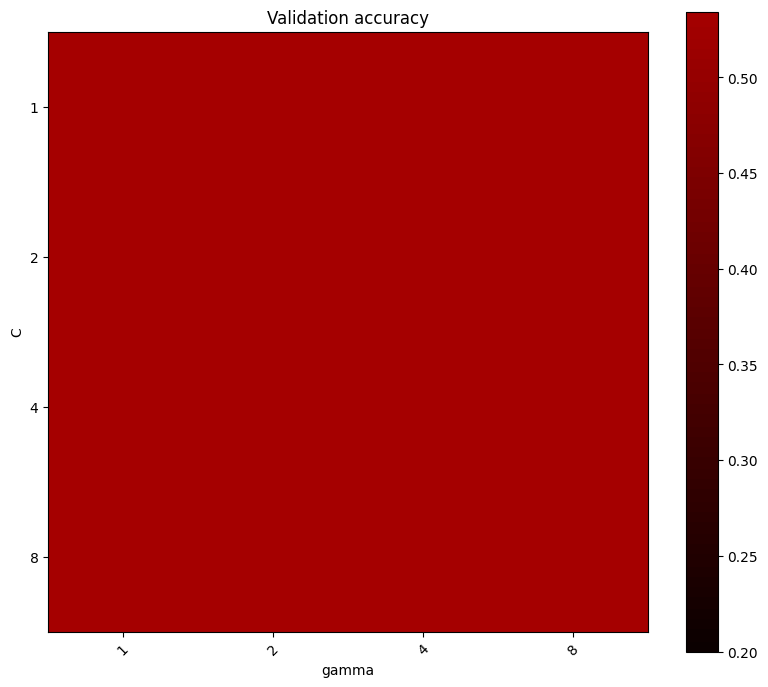

In [6]:
log_range = [pow(2, n) for n in range(0, 4)]
param_grid = {'C': log_range, 'gamma': log_range}
grid=GridSearchCV(SVC(kernel='linear'), param_grid=param_grid).fit(X_train, y_train['quality'])
plot_search_grid(grid)

## Conclusion

The best performing models I found for the wine quality dataset are the ensemble classifiers, which are well suited to picking up the kinds of nuances in the data that allow us to distinguish subtle differences between average-quality wines. Both of our ensemble classifiers achieve overall accuracy scores of nearly 0.7. Between the two, the random forest classifier takes top billing, as it is better overall and also very quick to train.

An interesting next step would be to analyze the red and white subsets of the dataset separately. This would allow us to see if our classifiers would perform better on each subset than on the combined dataset, and to investigate whether different features take precedence in the resulting models. 